# Flujo de Trabajo en ML

Antes de ejecutar ninguna celda, por favor asegúrate de activar e instanciar el entorno de paquetes para el tutorial. Para ello, usa los ficheros `Project.toml` y y `Manifest.toml` que se distribuyen en la página de la asignatura junto a este notebook (graba todo en una carpeta, por ejemplo de nombre `TutorialML`). Tras tener todo preparado, puedes volver a este notebook y comenzar a ejecutar las celdas.

**Importante**: La siguiente celda prepara el entorno cargando los paquetes necesarios.

In [2]:
using Pkg; Pkg.activate(""); Pkg.instantiate()

  Activating project at `c:\Users\fsancho\Nextcloud\Clases\IA\IA24-25\Practicas\TutorialesML`


In [3]:
using MLJ
MLJ_VERSION

v"0.20.7"

# Workflow de un vistazo

![](img/image-15.png)

# 1. Carga de Datos

In [6]:
import RDatasets
channing = RDatasets.dataset("boot", "channing")
first(channing, 4) |> pretty

┌─────────────────────────────────┬───────┬───────┬───────┬───────┐
│ Sex                             │ Entry │ Exit  │ Time  │ Cens  │
│ CategoricalValue{String, UInt8} │ Int32 │ Int32 │ Int32 │ Int32 │
│ Multiclass{2}                   │ Count │ Count │ Count │ Count │
├─────────────────────────────────┼───────┼───────┼───────┼───────┤
│ Male                            │ 782   │ 909   │ 127   │ 1     │
│ Male                            │ 1020  │ 1128  │ 108   │ 1     │
│ Male                            │ 856   │ 969   │ 113   │ 1     │
│ Male                            │ 915   │ 957   │ 42    │ 1     │
└─────────────────────────────────┴───────┴───────┴───────┴───────┘


Inspección de metadatos, incluidos los tipos científicos de columna:

In [7]:
schema(channing)

┌───────┬───────────────┬─────────────────────────────────┐
│ names │ scitypes      │ types                           │
├───────┼───────────────┼─────────────────────────────────┤
│ Sex   │ Multiclass{2} │ CategoricalValue{String, UInt8} │
│ Entry │ Count         │ Int32                           │
│ Exit  │ Count         │ Int32                           │
│ Time  │ Count         │ Int32                           │
│ Cens  │ Count         │ Int32                           │
└───────┴───────────────┴─────────────────────────────────┘


Dividir horizontalmente los datos y barajar las filas. 

Aquí `y` es la columna `:Exit` y `X` una tabla con todo lo demás:

In [10]:
y, X = unpack(channing, ==(:Exit), rng=123)

(Int32[913, 911, 1001, 824, 1000, 985, 1013, 891, 952, 930  …  926, 1056, 932, 1024, 868, 1020, 804, 1012, 927, 1085], 462×4 DataFrame
 Row │ Sex     Entry  Time   Cens  
     │ Cat…    Int32  Int32  Int32 
─────┼─────────────────────────────
   1 │ Female    881     32      0
   2 │ Female    837     74      1
   3 │ Male      969     32      0
   4 │ Female    821      3      0
   5 │ Female    889    111      1
   6 │ Female    933     52      0
   7 │ Female    972     41      0
   8 │ Female    887      4      0
  ⋮  │   ⋮       ⋮      ⋮      ⋮
 456 │ Female    902    122      0
 457 │ Female    828     40      1
 458 │ Female    883    137      0
 459 │ Female    748     56      1
 460 │ Female    948     64      0
 461 │ Female    894     33      0
 462 │ Female    948    137      0
                   447 rows omitted)

Aquí `y` es la columna `:Exit` y `X` todo lo demás excepto `:Time`:

In [11]:
y, X = unpack(channing,
              ==(:Exit),
              !=(:Time);
              rng=123);
scitype(y)

AbstractVector{Count} (alias for AbstractArray{Count, 1})

In [12]:
schema(X)

┌───────┬───────────────┬─────────────────────────────────┐
│ names │ scitypes      │ types                           │
├───────┼───────────────┼─────────────────────────────────┤
│ Sex   │ Multiclass{2} │ CategoricalValue{String, UInt8} │
│ Entry │ Count         │ Int32                           │
│ Cens  │ Count         │ Int32                           │
└───────┴───────────────┴─────────────────────────────────┘


Corrección de tipos científicos erróneos en `X`:

In [13]:
X = coerce(X, :Exit=>Continuous, :Entry=>Continuous, :Cens=>Multiclass);
schema(X)

┌───────┬───────────────┬─────────────────────────────────┐
│ names │ scitypes      │ types                           │
├───────┼───────────────┼─────────────────────────────────┤
│ Sex   │ Multiclass{2} │ CategoricalValue{String, UInt8} │
│ Entry │ Continuous    │ Float64                         │
│ Cens  │ Multiclass{2} │ CategoricalValue{Int32, UInt32} │
└───────┴───────────────┴─────────────────────────────────┘


Carga de un conjunto de datos supervisados integrado:

In [14]:
table = load_iris();
schema(table)

┌──────────────┬───────────────┬──────────────────────────────────┐
│ names        │ scitypes      │ types                            │
├──────────────┼───────────────┼──────────────────────────────────┤
│ sepal_length │ Continuous    │ Float64                          │
│ sepal_width  │ Continuous    │ Float64                          │
│ petal_length │ Continuous    │ Float64                          │
│ petal_width  │ Continuous    │ Float64                          │
│ target       │ Multiclass{3} │ CategoricalValue{String, UInt32} │
└──────────────┴───────────────┴──────────────────────────────────┘


Carga de un conjunto de datos ya dividido en `X` e `y`:

In [15]:
X, y = @load_iris;
selectrows(X, 1:4) # selectrows funcions cuando `Tables.istable(X)==true`.

(sepal_length = [5.1, 4.9, 4.7, 4.6],
 sepal_width = [3.5, 3.0, 3.2, 3.1],
 petal_length = [1.4, 1.4, 1.3, 1.5],
 petal_width = [0.2, 0.2, 0.2, 0.2],)

In [16]:
y[1:4]

4-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "setosa"
 "setosa"
 "setosa"
 "setosa"

Dividir los datos verticalmente después de barajar las filas:

In [18]:
channing_train, channing_test = partition(channing, 0.6, rng=123)

(277×5 DataFrame
 Row │ Sex     Entry  Exit   Time   Cens  
     │ Cat…    Int32  Int32  Int32  Int32 
─────┼────────────────────────────────────
   1 │ Female    881    913     32      0
   2 │ Female    837    911     74      1
   3 │ Male      969   1001     32      0
   4 │ Female    821    824      3      0
   5 │ Female    889   1000    111      1
   6 │ Female    933    985     52      0
   7 │ Female    972   1013     41      0
   8 │ Female    887    891      4      0
  ⋮  │   ⋮       ⋮      ⋮      ⋮      ⋮
 271 │ Female    965   1102    137      0
 272 │ Female   1002   1010      8      0
 273 │ Female    939    978     39      1
 274 │ Female    900    926     26      0
 275 │ Female    955    990     35      1
 276 │ Female    919    931     12      1
 277 │ Female    831    925     94      0
                          262 rows omitted, 185×5 DataFrame
 Row │ Sex     Entry  Exit   Time   Cens  
     │ Cat…    Int32  Int32  Int32  Int32 
─────┼────────────────────────────────

O, si ya está dividido horizontalmente:

In [19]:
(Xtrain, Xtest), (ytrain, ytest) = partition((X, y), 0.6, multi=true, rng=123)

(((sepal_length = [6.7, 5.7, 7.2, 4.4, 5.6, 6.5, 4.4, 6.1, 5.4, 4.9  …  6.4, 5.5, 5.4, 4.8, 6.5, 4.9, 6.5, 6.7, 5.6, 6.4], sepal_width = [3.3, 2.8, 3.0, 2.9, 2.5, 3.0, 3.0, 2.9, 3.9, 2.5  …  3.1, 2.3, 3.7, 3.1, 3.0, 2.4, 2.8, 3.3, 2.9, 2.8], petal_length = [5.7, 4.1, 5.8, 1.4, 3.9, 5.2, 1.3, 4.7, 1.7, 4.5  …  5.5, 4.0, 1.5, 1.6, 5.5, 3.3, 4.6, 5.7, 3.6, 5.6], petal_width = [2.1, 1.3, 1.6, 0.2, 1.1, 2.0, 0.2, 1.4, 0.4, 1.7  …  1.8, 1.3, 0.2, 0.2, 1.8, 1.0, 1.5, 2.5, 1.3, 2.2]), (sepal_length = [6.0, 5.8, 6.7, 5.1, 5.0, 6.3, 5.7, 6.4, 6.1, 5.0  …  6.4, 6.8, 6.9, 6.1, 6.7, 5.0, 7.6, 6.3, 5.1, 5.0], sepal_width = [2.7, 2.6, 3.0, 3.8, 3.4, 2.8, 2.5, 3.2, 2.8, 3.5  …  2.7, 3.2, 3.1, 2.8, 2.5, 3.5, 3.0, 2.5, 3.8, 3.6], petal_length = [5.1, 4.0, 5.2, 1.9, 1.5, 5.1, 5.0, 4.5, 4.7, 1.6  …  5.3, 5.9, 5.4, 4.0, 5.8, 1.3, 6.6, 5.0, 1.6, 1.4], petal_width = [1.6, 1.2, 2.3, 0.4, 0.2, 1.5, 2.0, 1.5, 1.2, 0.6  …  1.9, 2.3, 2.1, 1.3, 1.8, 0.3, 2.1, 1.9, 0.2, 0.2])), (CategoricalArrays.CategoricalValue{S

## Búsqueda de modelos

Búsqueda de un modelo supervisado:

In [20]:
X, y = @load_boston
ms = models(matching(X, y))

70-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :constructor, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :target_in_fit, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = ARDRegressor, package_name = MLJScikitLearnInterface, ... )
 (name = AdaBoostRegressor, package_name = MLJScikitLearnInterface, ... )
 (name = BaggingRegressor, package_name = MLJScikitLearnInterface, ... )
 (name = BayesianRidgeRegressor, package_name = MLJScikitLearnInterface, ... )
 (name = CatBoostRegressor, package_name = CatBoost, 

In [21]:
ms[6]

(name = "ConstantRegressor",
 package_name = "MLJModels",
 is_supervised = true,
 abstract_type = Probabilistic,
 constructor = nothing,
 deep_properties = (),
 docstring = "```\nConstantRegressor\n```\n\nThis \"dummy\" probabilis...",
 fit_data_scitype = Tuple{Table, AbstractVector{Continuous}},
 human_name = "constant regressor",
 hyperparameter_ranges = (nothing,),
 hyperparameter_types = ("Type{D} where D<:Distributions.Sampleable",),
 hyperparameters = (:distribution_type,),
 implemented_methods = [:fitted_params, :predict],
 inverse_transform_scitype = Unknown,
 is_pure_julia = true,
 is_wrapper = false,
 iteration_parameter = nothing,
 load_path = "MLJModels.ConstantRegressor",
 package_license = "MIT",
 package_url = "https://github.com/JuliaAI/MLJModels.jl",
 package_uuid = "d491faf4-2d78-11e9-2867-c94bc002c0b7",
 predict_scitype = AbstractVector{ScientificTypesBase.Density{Continuous}},
 prediction_type = :probabilistic,
 reporting_operations = (),
 reports_feature_importance

In [22]:
models("Tree")

28-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :constructor, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :target_in_fit, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = ABODDetector, package_name = OutlierDetectionNeighbors, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = COFDetector, package_name = OutlierDetectionNeighbors, ... )
 (name = DNNDetector, package_name = OutlierDetectionNeighbors, ... )
 (name = DecisionTreeClassifier, package_name = BetaML, ... )
 (name

Una búsqueda más refinada:

In [24]:
models() do model
    matching(model, X, y) &&
    model.prediction_type == :deterministic &&
    model.is_pure_julia
end

28-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :constructor, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :target_in_fit, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = DecisionTreeRegressor, package_name = BetaML, ... )
 (name = DecisionTreeRegressor, package_name = DecisionTree, ... )
 (name = DeterministicConstantRegressor, package_name = MLJModels, ... )
 (name = ElasticNetRegressor, package_name = MLJLinearModels, ... )
 (name = EvoLinearRegressor, package_name = EvoLinear, ... )
 (name = EvoSpline

Búsqueda de un modelo no supervisado:

In [25]:
models(matching(X))

63-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :constructor, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :target_in_fit, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = ABODDetector, package_name = OutlierDetectionNeighbors, ... )
 (name = ABODDetector, package_name = OutlierDetectionPython, ... )
 (name = AffinityPropagation, package_name = MLJScikitLearnInterface, ... )
 (name = AgglomerativeClustering, package_name = MLJScikitLearnInterface, ... )
 (name = AutoEncoder, package_name = BetaML, ... )
 (

Obtener los metadatos de un tipo de modelo determinado:

In [26]:
info("PCA")
info("RidgeRegressor", pkg="MultivariateStats") # un tipo de modelo que aparece en múltiples paquetes

(name = "RidgeRegressor",
 package_name = "MultivariateStats",
 is_supervised = true,
 abstract_type = Deterministic,
 constructor = nothing,
 deep_properties = (),
 docstring = "```\nRidgeRegressor\n```\n\nA model type for construct...",
 fit_data_scitype =
     Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{Continuous}},
 human_name = "ridge regressor",
 hyperparameter_ranges = (nothing, nothing),
 hyperparameter_types = ("Union{Real, AbstractVecOrMat}", "Bool"),
 hyperparameters = (:lambda, :bias),
 implemented_methods = [:clean!, :fit, :fitted_params, :predict],
 inverse_transform_scitype = Unknown,
 is_pure_julia = true,
 is_wrapper = false,
 iteration_parameter = nothing,
 load_path = "MLJMultivariateStatsInterface.RidgeRegressor",
 package_license = "MIT",
 package_url = "https://github.com/JuliaStats/MultivariateStats.jl",
 package_uuid = "6f286f6a-111f-5878-ab1e-185364afe411",
 predict_scitype = AbstractVector{Continuous},
 prediction_type = :deterministic,
 repor

## Instanciar un modelo

Asume que `MLJDecisionTreeClassifier` está en tu entorno.

In [27]:
Tree = @load DecisionTreeClassifier pkg=DecisionTree
tree = Tree(min_samples_split=5, max_depth=4)

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\loading.jl:159


DecisionTreeClassifier(
  max_depth = 4, 
  min_samples_leaf = 1, 
  min_samples_split = 5, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  display_depth = 5, 
  feature_importance = :impurity, 
  rng = Random._GLOBAL_RNG())

o

In [28]:
tree = (@load DecisionTreeClassifier pkg=DecisionTree)()
tree.min_samples_split = 5
tree.max_depth = 4

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\loading.jl:159


4

## Evaluar un modelo

In [29]:
X, y = @load_boston  # una tabla y un vector
KNN = @load KNNRegressor
knn = KNN()
evaluate(knn, X, y,
         resampling=CV(nfolds=5),
         measure=[RootMeanSquaredError(), LPLoss(1)])

import NearestNeighborModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\loading.jl:159
Evaluating over 5 folds: 100%[=========================] Time: 0:00:02


PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬────────────────────────┬───────────┬─────────────┐
│   │ measure                │ operation │ measurement │
├───┼────────────────────────┼───────────┼─────────────┤
│ A │ RootMeanSquaredError() │ predict   │ 8.77        │
│ B │ LPLoss(                │ predict   │ 6.02        │
│   │   p = 1)               │           │             │
└───┴────────────────────────┴───────────┴─────────────┘
┌───┬───────────────────────────────┬─────────┐
│   │ per_fold                      │ 1.96*SE │
├───┼───────────────────────────────┼─────────┤
│ A │ [8.53, 8.8, 10.7, 9.43, 5.59] │ 1.84    │
│ B │ [6.52, 5.7, 7.65, 6.09, 4.11] │ 1.26    │
└───┴───────────────────────────────┴─────────┘


Ten en cuenta que `RootMeanSquaredError()` tiene el alias `rms` y `LPLoss(1)` tiene los alias `l1`, `mae`. 

Ejecuta `measures()` para listar todas las pérdidas y puntuaciones y sus alias, o consulta StatisticalMeasures.jl [docs](https://juliaai.github.io/StatisticalMeasures.jl/dev/).

##  fit/evaluate/predict a mano y básico

In [30]:
using DataFrames
crabs = load_crabs() |> DataFrames.DataFrame
schema(crabs)

┌───────┬───────────────┬──────────────────────────────────┐
│ names │ scitypes      │ types                            │
├───────┼───────────────┼──────────────────────────────────┤
│ sp    │ Multiclass{2} │ CategoricalValue{String, UInt32} │
│ sex   │ Multiclass{2} │ CategoricalValue{String, UInt32} │
│ index │ Count         │ Int64                            │
│ FL    │ Continuous    │ Float64                          │
│ RW    │ Continuous    │ Float64                          │
│ CL    │ Continuous    │ Float64                          │
│ CW    │ Continuous    │ Float64                          │
│ BD    │ Continuous    │ Float64                          │
└───────┴───────────────┴──────────────────────────────────┘


In [32]:
y, X = unpack(crabs, ==(:sp), !in([:index, :sex]); rng=123)

Tree = @load DecisionTreeClassifier pkg=DecisionTree
tree = Tree(max_depth=2) # hide

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\loading.jl:159


DecisionTreeClassifier(
  max_depth = 2, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  display_depth = 5, 
  feature_importance = :impurity, 
  rng = Random._GLOBAL_RNG())

Unir el modelo y los datos en una *máquina*, que además, almacenará los parámetros aprendidos (*fitresults*) cuando se ajusten:


In [33]:
mach = machine(tree, X, y)

untrained Machine; caches model-specific representations of data
  model: DecisionTreeClassifier(max_depth = 2, …)
  args: 
    1:	Source @341 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @057 ⏎ AbstractVector{Multiclass{2}}


Dividir los índices de fila en filas de entrenamiento y de evaluación:

In [35]:
train, test = partition(eachindex(y), 0.7); # División 70:30

Ajustar en el conjunto de datos de entrenamiento y evaluar en el conjunto de datos de prueba:

In [36]:
fit!(mach, rows=train)
yhat = predict(mach, X[test,:])
LogLoss(tol=1e-4)(yhat, y[test])

┌ Info: Training machine(DecisionTreeClassifier(max_depth = 2, …), …).
└ @ MLJBase C:\Users\fsancho\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


1.0788055664326648

Ten en cuenta que `LogLoss()` tiene los alias `log_loss` y `cross_entropy`. 

Predecir en el nuevo conjunto de datos:

In [37]:
Xnew = (FL = rand(3), RW = rand(3), CL = rand(3), CW = rand(3), BD = rand(3))
predict(mach, Xnew)      # un vector de distribuciones

3-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{2}, String, UInt32, Float64}:
 UnivariateFinite{Multiclass{2}}(B=>0.667, O=>0.333)
 UnivariateFinite{Multiclass{2}}(B=>0.667, O=>0.333)
 UnivariateFinite{Multiclass{2}}(B=>0.667, O=>0.333)

In [38]:
predict_mode(mach, Xnew) # un vector de predicciones-puntuales

3-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "B"
 "B"
 "B"

## Más ejemplos de evaluación del rendimiento

Evaluar directamente el modelo + los datos:

In [39]:
evaluate(tree, X, y,
         resampling=Holdout(fraction_train=0.7, shuffle=true, rng=1234),
         measure=[LogLoss(), Accuracy()])

PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ LogLoss(             │ predict      │ 1.12        │
│   │   tol = 2.22045e-16) │              │             │
│ B │ Accuracy()           │ predict_mode │ 0.683       │
└───┴──────────────────────┴──────────────┴─────────────┘


Si una máquina ya está definida, como arriba:

In [40]:
evaluate!(mach,
          resampling=Holdout(fraction_train=0.7, shuffle=true, rng=1234),
          measure=[LogLoss(), Accuracy()])

PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ LogLoss(             │ predict      │ 1.12        │
│   │   tol = 2.22045e-16) │              │             │
│ B │ Accuracy()           │ predict_mode │ 0.683       │
└───┴──────────────────────┴──────────────┴─────────────┘


Uso de la validación cruzada:

In [41]:
evaluate!(mach, resampling=CV(nfolds=5, shuffle=true, rng=1234),
          measure=[LogLoss(), Accuracy()])

PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ LogLoss(             │ predict      │ 0.748       │
│   │   tol = 2.22045e-16) │              │             │
│ B │ Accuracy()           │ predict_mode │ 0.7         │
└───┴──────────────────────┴──────────────┴─────────────┘
┌───┬───────────────────────────────────┬─────────┐
│   │ per_fold                          │ 1.96*SE │
├───┼───────────────────────────────────┼─────────┤
│ A │ [0.552, 0.534, 0.44, 0.693, 1.52] │ 0.432   │
│ B │ [0.775, 0.7, 0.8, 0.6, 0.625]     │ 0.0866  │
└───┴───────────────────────────────────┴─────────┘


Con pares de índices de fila de entrenamiento/prueba especificados por el usuario:

In [42]:
f1, f2, f3 = 1:13, 14:26, 27:36
pairs = [(f1, vcat(f2, f3)), (f2, vcat(f3, f1)), (f3, vcat(f1, f2))];
evaluate!(mach,
          resampling=pairs,
          measure=[LogLoss(), Accuracy()])

Evaluating over 3 folds: 100%[=========================] Time: 0:00:00


PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ LogLoss(             │ predict      │ 3.8         │
│   │   tol = 2.22045e-16) │              │             │
│ B │ Accuracy()           │ predict_mode │ 0.736       │
└───┴──────────────────────┴──────────────┴─────────────┘
┌───┬───────────────────────┬─────────┐
│   │ per_fold              │ 1.96*SE │
├───┼───────────────────────┼─────────┤
│ A │ [5.1, 3.38, 3.01]     │ 1.55    │
│ B │ [0.696, 0.739, 0.769] │ 0.0513  │
└───┴───────────────────────┴─────────┘


Cambio de un hiperparámetro y reevaluación:

In [43]:
tree.max_depth = 3
evaluate!(mach,
          resampling=CV(nfolds=5, shuffle=true, rng=1234),
          measure=[LogLoss(), Accuracy()])

PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ LogLoss(             │ predict      │ 1.19        │
│   │   tol = 2.22045e-16) │              │             │
│ B │ Accuracy()           │ predict_mode │ 0.865       │
└───┴──────────────────────┴──────────────┴─────────────┘
┌───┬────────────────────────────────┬─────────┐
│   │ per_fold                       │ 1.96*SE │
├───┼────────────────────────────────┼─────────┤
│ A │ [1.26, 0.2, 0.199, 2.15, 2.15] │ 0.957   │
│ B │ [0.8, 0.95, 0.975, 0.8, 0.8]   │ 0.0877  │
└───┴────────────────────────────────┴─────────┘


##  Inspección de los resultados de entrenamiento

Ajustar un modelo de mínimos cuadrados ordinarios a unos datos sintéticos:

In [44]:
x1 = rand(100)
x2 = rand(100)

X = (x1=x1, x2=x2)
y = x1 - 2x2 + 0.1*rand(100);

OLS = @load LinearRegressor pkg=GLM
ols = OLS()
mach =  machine(ols, X, y) |> fit!

import MLJGLMInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\loading.jl:159
┌ Info: Training machine(LinearRegressor(fit_intercept = true, …), …).
└ @ MLJBase C:\Users\fsancho\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


trained Machine; caches model-specific representations of data
  model: LinearRegressor(fit_intercept = true, …)
  args: 
    1:	Source @362 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @945 ⏎ AbstractVector{Continuous}


Obtener una tupla con nombre que representa los parámetros aprendidos, legible por humanos si procede:

In [45]:
fitted_params(mach)

(features = [:x1, :x2],
 coef = [0.985398873087766, -2.010630265087293],
 intercept = 0.06738039392202504,)

Obtener otra información relacionada con el entrenamiento:

In [46]:
report(mach)

(stderror = [0.007776573292181543, 0.009937629806616378, 0.009373157649786752],
 dof_residual = 97.0,
 vcov = [6.047509216867129e-5 -5.204455337471434e-5 -4.987245393694766e-5; -5.204455337471434e-5 9.875648617335026e-5 4.77514378265409e-6; -4.987245393694766e-5 4.77514378265409e-6 8.78560843277559e-5],
 deviance = 0.07231085374832054,
 coef_table = ─────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error        t  Pr(>|t|)  Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   0.0673804  0.00777657     8.66    <1e-12   0.051946   0.0828147
x1            0.985399   0.00993763    99.16    <1e-98   0.965675   1.00512
x2           -2.01063    0.00937316  -214.51    <1e-99  -2.02923   -1.99203
─────────────────────────────────────────────────────────────────────────────,)

##  fit/transform básico para modelos no supervisados

Cargar datos:

In [47]:
X, y = @load_iris  # una tabla y un vector
train, test = partition(eachindex(y), 0.97, shuffle=true, rng=123)

([125, 100, 130, 9, 70, 148, 39, 64, 6, 107  …  110, 59, 139, 21, 112, 144, 140, 72, 109, 41], [106, 147, 47, 5])

Instanciar y ajustar el modelo/máquina:

In [48]:
PCA = @load PCA
pca = PCA(maxoutdim=2)
mach = machine(pca, X)
fit!(mach, rows=train)

import MLJMultivariateStatsInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\loading.jl:159
┌ Info: Training machine(PCA(maxoutdim = 2, …), …).
└ @ MLJBase C:\Users\fsancho\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


trained Machine; caches model-specific representations of data
  model: PCA(maxoutdim = 2, …)
  args: 
    1:	Source @009 ⏎ Table{AbstractVector{Continuous}}


Transformar los datos seleccionados vinculados a la máquina:

In [49]:
MLJ.transform(mach, rows=test);

Transformar nuevos datos:

In [50]:
Xnew = (sepal_length=rand(3), sepal_width=rand(3),
        petal_length=rand(3), petal_width=rand(3));
MLJ.transform(mach, Xnew)

(x1 = [5.012531153758396, 4.3886896679593494, 4.607798309506269],
 x2 = [-4.751633521810584, -4.893902603898789, -4.232745644756746],)

##  Invertir las transformaciones aprendidas

In [51]:
y = rand(100);
stand = Standardizer()
mach = machine(stand, y)
fit!(mach)
z = MLJ.transform(mach, y);
@assert inverse_transform(mach, z) ≈ y # true

┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase C:\Users\fsancho\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


## Ajuste de hiperparámetros anidados

In [52]:
X, y = @load_iris

((sepal_length = [5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.6, 5.0, 4.4, 4.9  …  6.7, 6.9, 5.8, 6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9], sepal_width = [3.5, 3.0, 3.2, 3.1, 3.6, 3.9, 3.4, 3.4, 2.9, 3.1  …  3.1, 3.1, 2.7, 3.2, 3.3, 3.0, 2.5, 3.0, 3.4, 3.0], petal_length = [1.4, 1.4, 1.3, 1.5, 1.4, 1.7, 1.4, 1.5, 1.4, 1.5  …  5.6, 5.1, 5.1, 5.9, 5.7, 5.2, 5.0, 5.2, 5.4, 5.1], petal_width = [0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.3, 0.2, 0.2, 0.1  …  2.4, 2.3, 1.9, 2.3, 2.5, 2.3, 1.9, 2.0, 2.3, 1.8]), CategoricalArrays.CategoricalValue{String, UInt32}["setosa", "setosa", "setosa", "setosa", "setosa", "setosa", "setosa", "setosa", "setosa", "setosa"  …  "virginica", "virginica", "virginica", "virginica", "virginica", "virginica", "virginica", "virginica", "virginica", "virginica"])

Definir un modelo con hiperparámetros anidados:

In [53]:
Tree = @load DecisionTreeClassifier pkg=DecisionTree
tree = Tree()
forest = EnsembleModel(model=tree, n=300)

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\loading.jl:159


ProbabilisticEnsembleModel(
  model = DecisionTreeClassifier(
        max_depth = -1, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = 0, 
        post_prune = false, 
        merge_purity_threshold = 1.0, 
        display_depth = 5, 
        feature_importance = :impurity, 
        rng = Random._GLOBAL_RNG()), 
  atomic_weights = Float64[], 
  bagging_fraction = 0.8, 
  rng = Random._GLOBAL_RNG(), 
  n = 300, 
  acceleration = CPU1{Nothing}(nothing), 
  out_of_bag_measure = Any[])

Definir los rangos de los hiperparámetros que se van a ajustar:

In [54]:
r1 = range(forest, :bagging_fraction, lower=0.5, upper=1.0, scale=:log10)

NumericRange(0.5 ≤ bagging_fraction ≤ 1.0; origin=0.75, unit=0.25; on log10 scale)

In [55]:
r2 = range(forest, :(model.n_subfeatures), lower=1, upper=4) # nested

NumericRange(1 ≤ model.n_subfeatures ≤ 4; origin=2.5, unit=1.5)

Envolver el modelo en una estrategia de ajuste:

In [56]:
tuned_forest = TunedModel(model=forest,
                          tuning=Grid(resolution=12),
                          resampling=CV(nfolds=6),
                          ranges=[r1, r2],
                          measure=BrierLoss())

ProbabilisticTunedModel(
  model = ProbabilisticEnsembleModel(
        model = DecisionTreeClassifier(max_depth = -1, …), 
        atomic_weights = Float64[], 
        bagging_fraction = 0.8, 
        rng = Random._GLOBAL_RNG(), 
        n = 300, 
        acceleration = CPU1{Nothing}(nothing), 
        out_of_bag_measure = Any[]), 
  tuning = Grid(
        goal = nothing, 
        resolution = 12, 
        shuffle = true, 
        rng = Random._GLOBAL_RNG()), 
  resampling = CV(
        nfolds = 6, 
        shuffle = false, 
        rng = Random._GLOBAL_RNG()), 
  measure = BrierLoss(), 
  weights = nothing, 
  class_weights = nothing, 
  operation = nothing, 
  range = MLJBase.NumericRange{T, MLJBase.Bounded, Symbol} where T[NumericRange(0.5 ≤ bagging_fraction ≤ 1.0; origin=0.75, unit=0.25; on log10 scale), NumericRange(1 ≤ model.n_subfeatures ≤ 4; origin=2.5, unit=1.5)], 
  selection_heuristic = MLJTuning.NaiveSelection(nothing), 
  train_best = true, 
  repeats = 1, 
  n = nothing, 

Vincula el modelo envuelto a los datos:

In [57]:
mach = machine(tuned_forest, X, y)

untrained Machine; does not cache data
  model: ProbabilisticTunedModel(model = ProbabilisticEnsembleModel(model = DecisionTreeClassifier(max_depth = -1, …), …), …)
  args: 
    1:	Source @725 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @793 ⏎ AbstractVector{Multiclass{3}}


El ajuste de la máquina resultante optimiza los hiperparámetros especificados en `range`, utilizando las estrategias de `tuning` y `resampling` especificadas y la `measure` de rendimiento (posiblemente un vector de medidas), y reentrena en todos los datos vinculados a la máquina:

In [58]:
fit!(mach)

┌ Info: Training machine(ProbabilisticTunedModel(model = ProbabilisticEnsembleModel(model = DecisionTreeClassifier(max_depth = -1, …), …), …), …).
└ @ MLJBase C:\Users\fsancho\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Attempting to evaluate 48 models.
└ @ MLJTuning C:\Users\fsancho\.julia\packages\MLJTuning\vMe8s\src\tuned_models.jl:762
Evaluating over 48 metamodels: 100%[=========================] Time: 0:00:09


trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = ProbabilisticEnsembleModel(model = DecisionTreeClassifier(max_depth = -1, …), …), …)
  args: 
    1:	Source @725 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @793 ⏎ AbstractVector{Multiclass{3}}


Inspección del modelo óptimo:

In [59]:
F = fitted_params(mach)

(best_model = ProbabilisticEnsembleModel(model = DecisionTreeClassifier(max_depth = -1, …), …),
 best_fitted_params = (fitresult = WrappedEnsemble(atom = DecisionTreeClassifier(max_depth = -1, …), …),),)

In [60]:
F.best_model

ProbabilisticEnsembleModel(
  model = DecisionTreeClassifier(
        max_depth = -1, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = 3, 
        post_prune = false, 
        merge_purity_threshold = 1.0, 
        display_depth = 5, 
        feature_importance = :impurity, 
        rng = Random._GLOBAL_RNG()), 
  atomic_weights = Float64[], 
  bagging_fraction = 0.5325205447199813, 
  rng = Random._GLOBAL_RNG(), 
  n = 300, 
  acceleration = CPU1{Nothing}(nothing), 
  out_of_bag_measure = Any[])

Inspección de los detalles del procedimiento de puesta a punto:

In [61]:
r = report(mach);
keys(r)

(:best_model, :best_history_entry, :history, :best_report, :plotting)

In [62]:
r.history[[1,end]]

2-element Vector{@NamedTuple{model::MLJEnsembles.ProbabilisticEnsembleModel{MLJDecisionTreeInterface.DecisionTreeClassifier}, measure::Vector{StatisticalMeasuresBase.RobustMeasure{StatisticalMeasuresBase.FussyMeasure{StatisticalMeasuresBase.RobustMeasure{StatisticalMeasures._BrierLossType}, typeof(StatisticalMeasures.l2_check)}}}, measurement::Vector{Float64}, per_fold::Vector{Vector{Float64}}, evaluation::MLJBase.CompactPerformanceEvaluation{MLJEnsembles.ProbabilisticEnsembleModel{MLJDecisionTreeInterface.DecisionTreeClassifier}, Vector{StatisticalMeasuresBase.RobustMeasure{StatisticalMeasuresBase.FussyMeasure{StatisticalMeasuresBase.RobustMeasure{StatisticalMeasures._BrierLossType}, typeof(StatisticalMeasures.l2_check)}}}, Vector{Float64}, Vector{typeof(predict)}, Vector{Vector{Float64}}, Vector{Vector{Vector{Float64}}}, CV}}}:
 (model = ProbabilisticEnsembleModel(model = DecisionTreeClassifier(max_depth = -1, …), …), measure = [BrierLoss()], measurement = [0.09835362962962961], per_

Visualización de estos resultados:

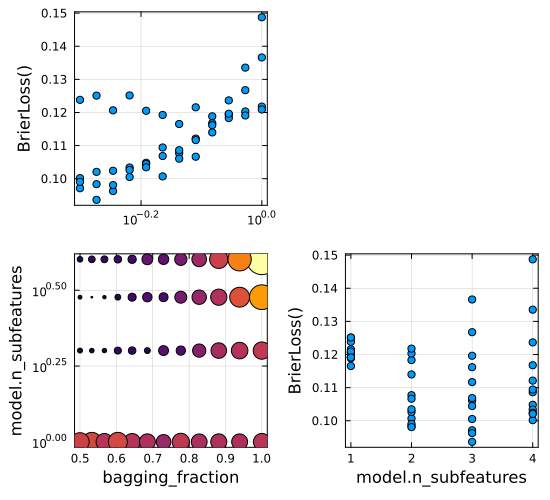

In [63]:
using Plots
plot(mach)

Predicción sobre nuevos datos utilizando el modelo optimizado entrenado sobre todos los datos:

In [64]:
predict(mach, Xnew)

3-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(setosa=>1.0, versicolor=>0.0, virginica=>0.0)
 UnivariateFinite{Multiclass{3}}(setosa=>0.533, versicolor=>0.42, virginica=>0.0467)
 UnivariateFinite{Multiclass{3}}(setosa=>1.0, versicolor=>0.0, virginica=>0.0)

## Construcción de pipelines lineales

Construcción de una pipeline lineal (no ramificada) con una transformación/transformación inversa objetivo *aprendida*:

In [65]:
X, y = @load_reduced_ames
KNN = @load KNNRegressor
knn_with_target = TransformedTargetModel(model=KNN(K=3), transformer=Standardizer())

import NearestNeighborModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\loading.jl:159


TransformedTargetModelDeterministic(
  model = KNNRegressor(
        K = 3, 
        algorithm = :kdtree, 
        metric = Distances.Euclidean(0.0), 
        leafsize = 10, 
        reorder = true, 
        weights = NearestNeighborModels.Uniform()), 
  transformer = Standardizer(
        features = Symbol[], 
        ignore = false, 
        ordered_factor = false, 
        count = false), 
  inverse = nothing, 
  cache = true)

In [66]:
pipe = (X -> coerce(X, :age=>Continuous)) |> OneHotEncoder() |> knn_with_target

DeterministicPipeline(
  f = var"#27#28"(), 
  one_hot_encoder = OneHotEncoder(
        features = Symbol[], 
        drop_last = false, 
        ordered_factor = true, 
        ignore = false), 
  transformed_target_model_deterministic = TransformedTargetModelDeterministic(
        model = KNNRegressor(K = 3, …), 
        transformer = Standardizer(features = Symbol[], …), 
        inverse = nothing, 
        cache = true), 
  cache = true)

Evaluar el pipeline (como se haría con cualquier otro modelo):

In [67]:
pipe.one_hot_encoder.drop_last = true # muta un hiperparámetro encajado
evaluate(pipe, X, y, resampling=Holdout(), measure=RootMeanSquaredError(), verbosity=2)

┌ Info: Training machine(DeterministicPipeline(f = #27, …), …).
└ @ MLJBase C:\Users\fsancho\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:one_hot_encoder, …).
└ @ MLJBase C:\Users\fsancho\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Spawning 9 sub-features to one-hot encode feature :OverallQual.
└ @ MLJModels C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\builtins\Transformers.jl:795
┌ Info: Spawning 24 sub-features to one-hot encode feature :Neighborhood.
└ @ MLJModels C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\builtins\Transformers.jl:795
┌ Info: Spawning 14 sub-features to one-hot encode feature :MSSubClass.
└ @ MLJModels C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\builtins\Transformers.jl:795
┌ Info: Training machine(:transformed_target_model_deterministic, …).
└ @ MLJBase C:\Users\fsancho\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:transformer, …).
└ @ MLJBase C:\Users\fsancho\.jul

PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌────────────────────────┬───────────┬─────────────┐
│ measure                │ operation │ measurement │
├────────────────────────┼───────────┼─────────────┤
│ RootMeanSquaredError() │ predict   │ 51200.0     │
└────────────────────────┴───────────┴─────────────┘


Inspección de los parámetros aprendidos en una pipeline:

In [68]:
mach = machine(pipe, X, y) |> fit!
F = fitted_params(mach)
F.transformed_target_model_deterministic.model

┌ Info: Training machine(DeterministicPipeline(f = #27, …), …).
└ @ MLJBase C:\Users\fsancho\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:one_hot_encoder, …).
└ @ MLJBase C:\Users\fsancho\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Spawning 9 sub-features to one-hot encode feature :OverallQual.
└ @ MLJModels C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\builtins\Transformers.jl:795
┌ Info: Spawning 24 sub-features to one-hot encode feature :Neighborhood.
└ @ MLJModels C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\builtins\Transformers.jl:795
┌ Info: Spawning 14 sub-features to one-hot encode feature :MSSubClass.
└ @ MLJModels C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\builtins\Transformers.jl:795
┌ Info: Training machine(:transformed_target_model_deterministic, …).
└ @ MLJBase C:\Users\fsancho\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:transformer, …).
└ @ MLJBase C:\Users\fsancho\.jul

(tree = NearestNeighbors.KDTree{StaticArraysCore.SVector{56, Float64}, Distances.Euclidean, Float64, StaticArraysCore.SVector{56, Float64}}
  Number of points: 1456
  Dimensions: 56
  Metric: Distances.Euclidean(0.0)
  Reordered: true,)

Construcción de una pipeline lineal (no ramificada) con una transformación/transformación inversa objetivo *estática* (no aprendida):

In [69]:
Tree = @load DecisionTreeRegressor pkg=DecisionTree verbosity=0
tree_with_target = TransformedTargetModel(model=Tree(),
                                          transformer=y -> log.(y),
                                          inverse = z -> exp.(z))
pipe2 = (X -> coerce(X, :age=>Continuous)) |> OneHotEncoder() |> tree_with_target

DeterministicPipeline(
  f = var"#33#34"(), 
  one_hot_encoder = OneHotEncoder(
        features = Symbol[], 
        drop_last = false, 
        ordered_factor = true, 
        ignore = false), 
  transformed_target_model_deterministic = TransformedTargetModelDeterministic(
        model = DecisionTreeRegressor(max_depth = -1, …), 
        transformer = var"#29#31"(), 
        inverse = var"#30#32"(), 
        cache = true), 
  cache = true)

## Creación de un conjunto homogéneo de modelos

In [70]:
X, y = @load_iris
Tree = @load DecisionTreeClassifier pkg=DecisionTree
tree = Tree()
forest = EnsembleModel(model=tree, bagging_fraction=0.8, n=300)
mach = machine(forest, X, y)
evaluate!(mach, measure=LogLoss())

import MLJDecisionTreeInterface ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\fsancho\.julia\packages\MLJModels\8W54X\src\loading.jl:159
Evaluating over 6 folds:  33%[========>                ]  ETA: 0:00:00

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌──────────────────────┬───────────┬─────────────┐
│ measure              │ operation │ measurement │
├──────────────────────┼───────────┼─────────────┤
│ LogLoss(             │ predict   │ 0.43        │
│   tol = 2.22045e-16) │           │             │
└──────────────────────┴───────────┴─────────────┘
┌─────────────────────────────────────────────────┬─────────┐
│ per_fold                                        │ 1.96*SE │
├─────────────────────────────────────────────────┼─────────┤
│ [3.89e-15, 3.89e-15, 0.302, 1.62, 0.341, 0.312] │ 0.531   │
└─────────────────────────────────────────────────┴─────────┘


## Curvas de rendimiento

Generar un gráfico de rendimiento, en función de algún hiperparámetro (basándose en el ejemplo anterior).

Curva de rendimiento única:

In [71]:
r = range(forest, :n, lower=1, upper=1000, scale=:log10)
curve = learning_curve(mach,
                       range=r,
                       resampling=Holdout(),
                       resolution=50,
                       measure=LogLoss(),
                       verbosity=0)

(parameter_name = "n",
 parameter_scale = :log10,
 parameter_values = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11  …  281, 324, 373, 429, 494, 569, 655, 754, 869, 1000],
 measurements = [9.611640903764574, 7.347360113935419, 7.424677601406042, 5.913396673344481, 5.864931813191956, 5.842088246099716, 5.850947799923275, 5.868590892644992, 5.835619031404115, 2.8266222940695958  …  1.2501198748648863, 1.2461889923416434, 1.242108636115014, 1.24144347038632, 1.2310689584585255, 1.2372565365183619, 1.2385988169865667, 1.2417516097745116, 1.2443517172188028, 1.2436942741328947],)

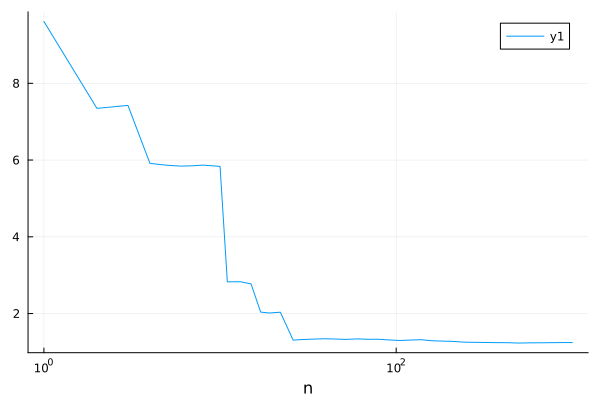

In [72]:
using Plots
plot(curve.parameter_values, curve.measurements,
     xlab=curve.parameter_name, xscale=curve.parameter_scale)

Curvas múltiples:

In [73]:
curve = learning_curve(mach,
                       range=r,
                       resampling=Holdout(),
                       measure=LogLoss(),
                       resolution=50,
                       rng_name=:rng,
                       rngs=4,
                       verbosity=0)

(parameter_name = "n",
 parameter_scale = :log10,
 parameter_values = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11  …  281, 324, 373, 429, 494, 569, 655, 754, 869, 1000],
 measurements = [4.004850376568572 9.611640903764574 16.820371581588002 9.611640903764574; 4.004850376568572 8.040507294495367 9.087929700674836 9.611640903764574; … ; 1.2054173243412156 1.2344732956339899 1.2623951829446378 1.2810218589470879; 1.211372410840192 1.2366023368521541 1.265007388225465 1.2788029336545665],)

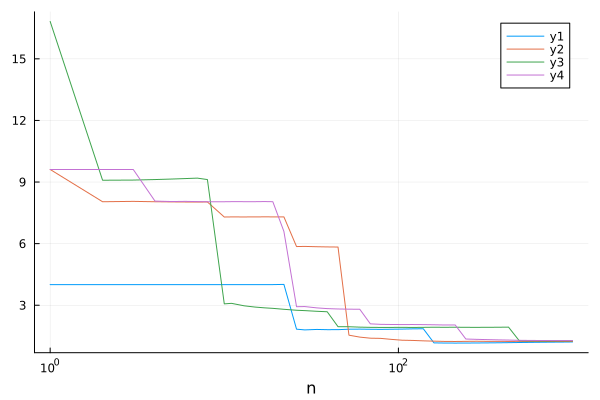

In [74]:
plot(curve.parameter_values, curve.measurements,
     xlab=curve.parameter_name, xscale=curve.parameter_scale)